In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

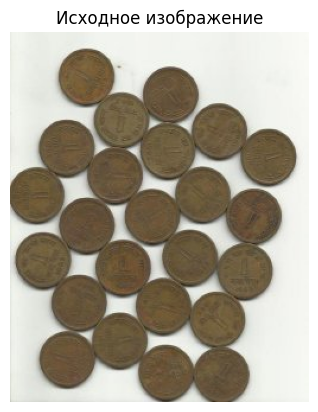

In [10]:
current_directory = os.path.dirname(os.getcwd())
image_path = os.path.join(current_directory, 'pictures', 'coins2.jpg')

image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Изображение по пути {image_path} не загружено!")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.imshow(image)
plt.title("Исходное изображение")
plt.axis('off')
plt.show()


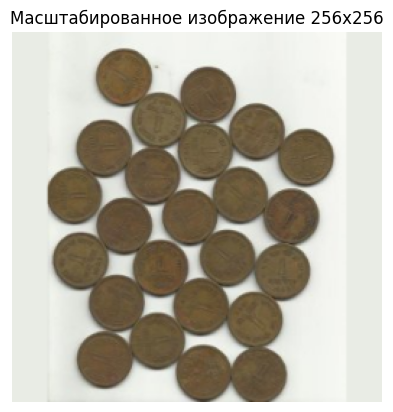

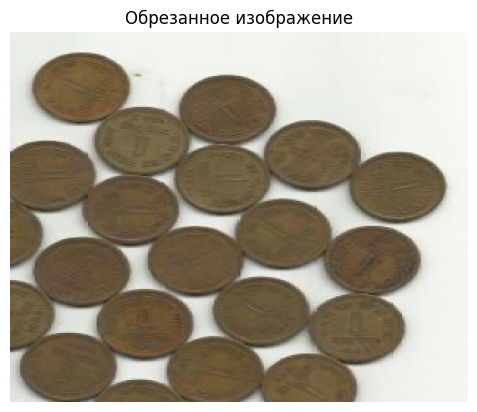

In [11]:
max_size, min_size = max(image.shape[:-1]), min(image.shape[:-1])
width, height = image.shape[:-1]

# квадратное изображения
img = np.zeros((max_size, max_size, 3), dtype=np.uint8)
img[:, :] = image[0, 0]

# Добавление изображения в центр квадрата
d2 = (max_size - min_size) // 2
if width > height:
    img[:, d2:d2 + height] = image
else:
    img[d2:d2 + width, :] = image

# Масштабирование изображения до 256x256
img_res = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

# Обрезание
crop_size = min(width, height)
x_center, y_center = width // 2, height // 2
x_start, y_start = x_center - crop_size // 2, y_center - crop_size // 2
cropped_image = image[y_start:y_start + crop_size, x_start:x_start + crop_size]

# Исходный размер
normalized_img = cv2.resize(cropped_image, (width, height), interpolation=cv2.INTER_AREA)


plt.imshow(img_res)
plt.title("Масштабированное изображение 256x256")
plt.axis('off')
plt.show()


plt.imshow(normalized_img)
plt.title("Обрезанное изображение")
plt.axis('off')
plt.show()

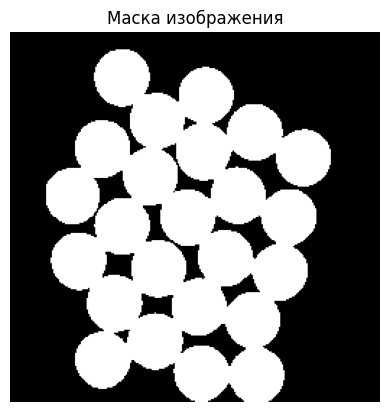

In [12]:
# Преобразование изображения
gray = cv2.cvtColor(img_res, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

# Поиск контуров и создание маски
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(img_res)

# Заполнение маски
for cntr in contours:
    cv2.drawContours(mask, [cntr], 0, (255,255,255), -1)

# инверсия.
mask = 255 - mask


plt.imshow(mask)
plt.title("Маска изображения")
plt.axis('off')
plt.show()

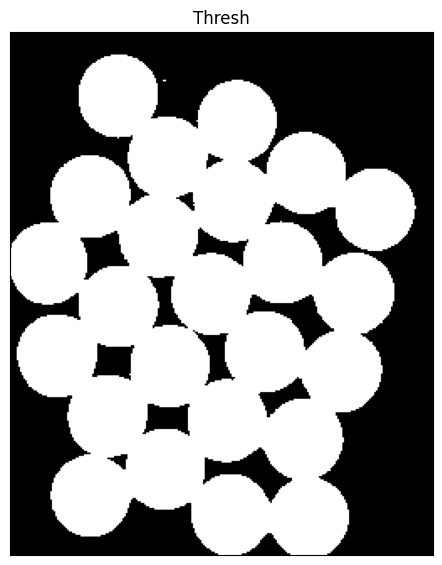

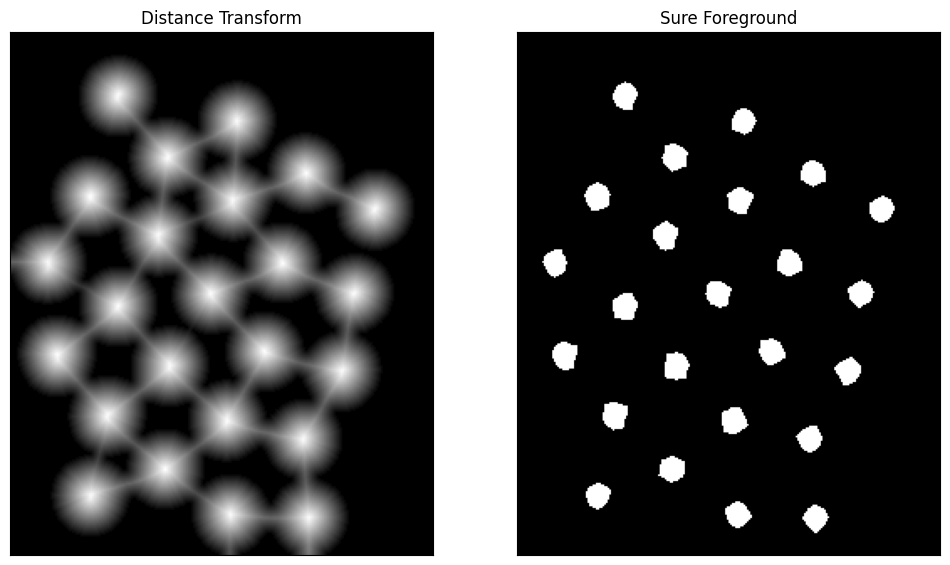

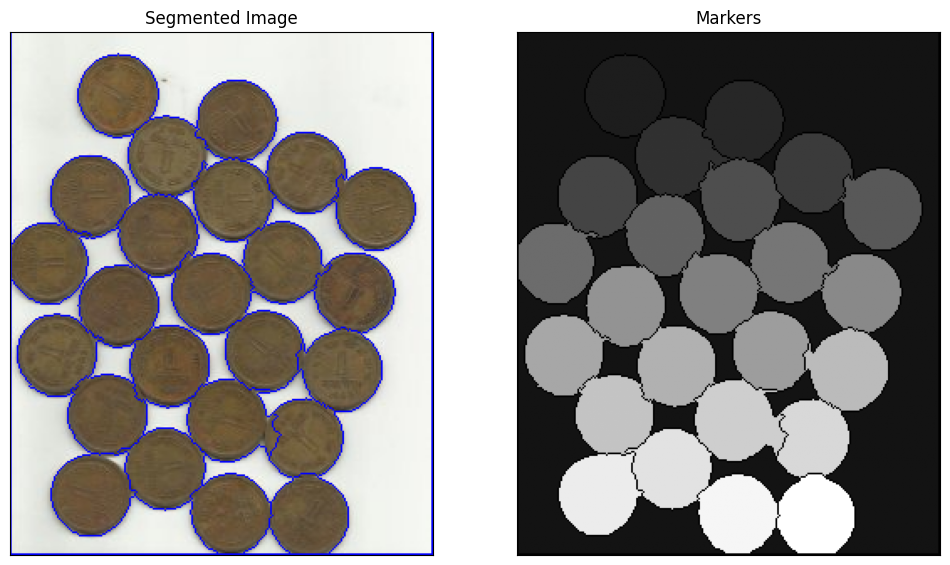

In [15]:
# Сегментация методом водораздела

img_seg = cv2.imread(image_path)



img_gray = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

# Пороговой сегментации
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.figure(figsize=(12, 12))
plt.subplot(122), plt.imshow(thresh, cmap='gray'), plt.title('Thresh')
plt.xticks([]), plt.yticks([])
plt.show()

# Удаление шума
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Область фона
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance Transform (Трансформация расстояний)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# Sure Foreground (Точный передний план)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Определение неизвестной области
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Отображение промежуточных результатов
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(dist_transform, cmap='gray'), plt.title('Distance Transform')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(sure_fg, cmap='gray'), plt.title('Sure Foreground')
plt.xticks([]), plt.yticks([])
plt.show()


ret, markers = cv2.connectedComponents(sure_fg)

# фон, 1
markers = markers + 1

# неизвестные области
markers[unknown == 255] = 0

# Применение алгоритма водораздела
markers = cv2.watershed(img_seg, markers)
# Segmented Image (Сегментированное изображение).Границы -1
img_seg[markers == -1] = [255, 0, 0]


plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_seg, cv2.COLOR_BGR2RGB)), plt.title('Segmented Image')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(markers, cmap='gray'), plt.title('Markers')
plt.xticks([]), plt.yticks([])
plt.show()

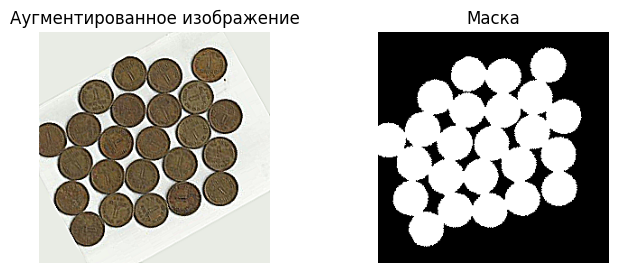

In [16]:
# Вращение изображения
def rotate(image, angle, center=None, scale=1.0):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h),
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=image[0,0])
    return rotated

# Генерация аугментированных изображений
def gen_random(images):
    out_images = []
    idx = np.random.randint(10000)
    angle = np.random.random() * 360
    blur_strength = np.random.randint(1, 5)

    for img in images:
        n_img = img.copy().astype(np.float64)

        # Вращение
        if idx % 2 == 0:
            n_img = rotate(n_img, angle)

        # Размытие
        if idx % 5 == 0:
            n_img = cv2.blur(n_img, (blur_strength, blur_strength))

            # plt.figure(figsize=(4, 4))
            # plt.imshow(n_img.astype(np.uint8))
            # plt.title("Изображение после размытия")
            # plt.axis('off')
            # plt.show()
            

        # Повышение резкости
        if idx % 5 == 3:
            kernel = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]])
            n_img = cv2.filter2D(n_img, -1, kernel)

        n_img = np.clip(n_img, 0, 255).astype(np.uint8)
        out_images.append(n_img)

    return out_images


i, m = gen_random([img_res, mask])


fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(i)
ax1.set_title("Аугментированное изображение")
ax1.axis('off')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(m)
ax2.set_title("Маска")
ax2.axis('off')

plt.show()


In [17]:
def save_gen(image, mask, count=100):
    save_path = os.path.join(current_directory, 'pictures', 'lab1_saved_images')
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    for i in range(count):
        img, msk = gen_random([image, mask])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"{save_path}/image_{i}.jpg", img)
        cv2.imwrite(f"{save_path}/mask_{i}.jpg", msk)


save_gen(img_res, mask)
